In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback
from scipy.linalg import svd, inv, eig
from scipy.special import erf

#sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-15 16:36:41.771094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
import utils

In [95]:
def plot_matrix(m, ax, scale=1.0):
    mmax = np.max(np.abs(m)) / scale
    ax.imshow(m, cmap="bwr", vmin=-mmax, vmax=mmax, interpolation="nearest")
    ax.grid(False)

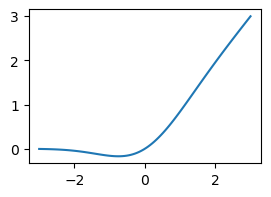

In [4]:
def gelu(x):
    return x / 2 * (1 + erf(x / np.sqrt(2)))

fig, ax = plt.subplots(1,1,figsize=(3,2))
x_range = np.linspace(-3,3,100)
ax.plot(x_range, gelu(x_range));

In [5]:
def plot_fft(mat, ax, shift=+np.pi/2, scale=1):
    
    fft = np.fft.rfft(mat, axis=-1)
    fft_abs, fft_arg = np.abs(fft), np.angle(fft)

    fft_arg += np.pi
    fft_arg[1::2] += shift
    fft_arg = fft_arg % (2*np.pi)

    hue = fft_arg / (2*np.pi)
    saturation = np.clip(fft_abs / np.max(fft_abs) * scale, 0, 1)
    value = np.ones_like(hue)
    hsv = np.stack([hue, saturation, value], axis=-1)
    rgb = hsv_to_rgb(hsv)
    y_max, x_max = rgb.shape[:2]

    ax.imshow(rgb, interpolation="nearest")

    ax.grid(True, which="minor", color='black', linewidth=0.5, alpha=0.1)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which="major", color='black', linewidth=0.5, alpha=0.3)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))

In [80]:
run = utils.TrainingRun()
#P, model = run.load_state("../output/mlp_grokking-230411-124054")
#P, model = run.load_state("../output/mlp_grokking-230412-092835")
#P, model = run.load_state("../output/mlp_grokking-230412-100753")
#P, model = run.load_state("../output/mlp_grokking-230413-073742")
P, model = run.load_state("../output/mlp_grokking-230415-145554")

In [81]:
weights = model.get_weights()
print([ w.shape for w in weights ])

w_emb = weights[0]
w_mlp = weights[1].reshape(2,128,128)
w_uem = weights[2]

print(w_emb.shape, w_mlp.shape, w_uem.shape)

[(113, 128), (2, 128, 1, 128), (128, 128)]
(113, 128) (2, 128, 128) (128, 128)


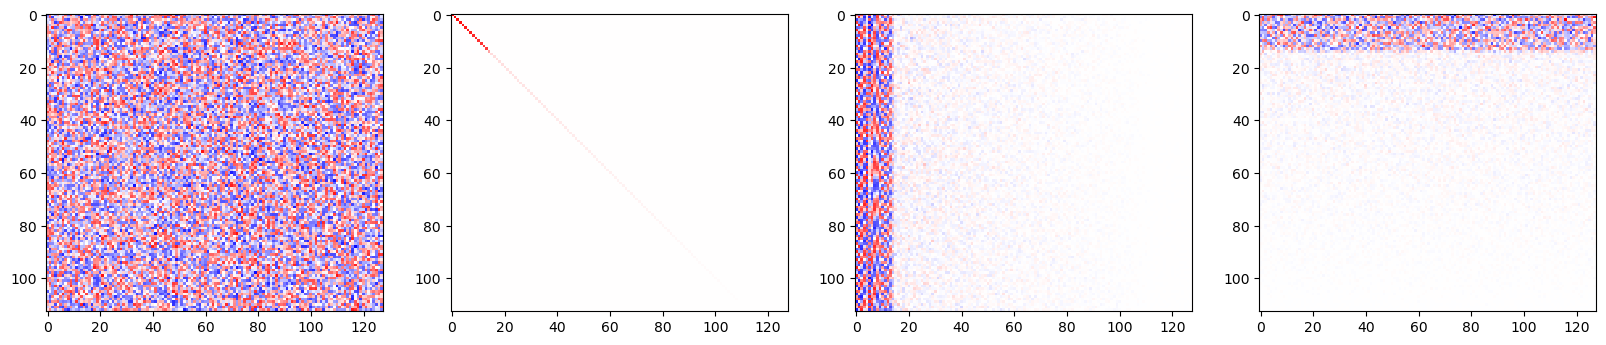

In [82]:
u_emb, s_emb, vt_emb = svd(w_emb)
w_emb_diag = u_emb.T @ w_emb @ vt_emb.T
#plt.matshow(w_emb_diag)
fig, axs = plt.subplots(1,4, figsize=(20,5))
plot_matrix(w_emb, axs[0])
plot_matrix(w_emb_diag, axs[1])
plot_matrix(u_emb @ w_emb_diag, axs[2])
plot_matrix(w_emb_diag @ vt_emb, axs[3]);

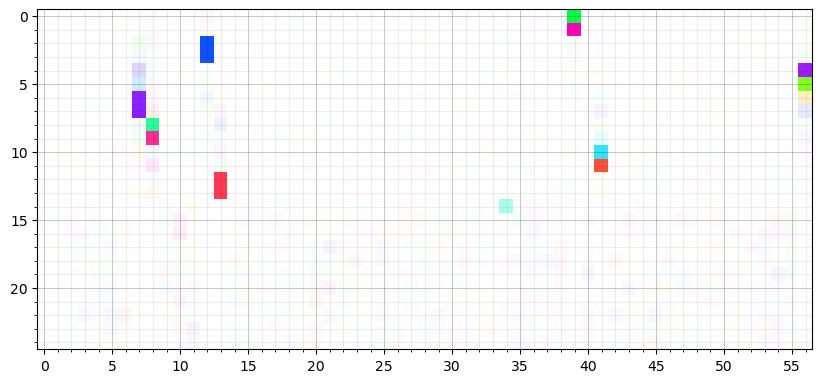

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

plot_fft((u_emb @ w_emb_diag).T[:25], ax, shift=-np.pi/2)

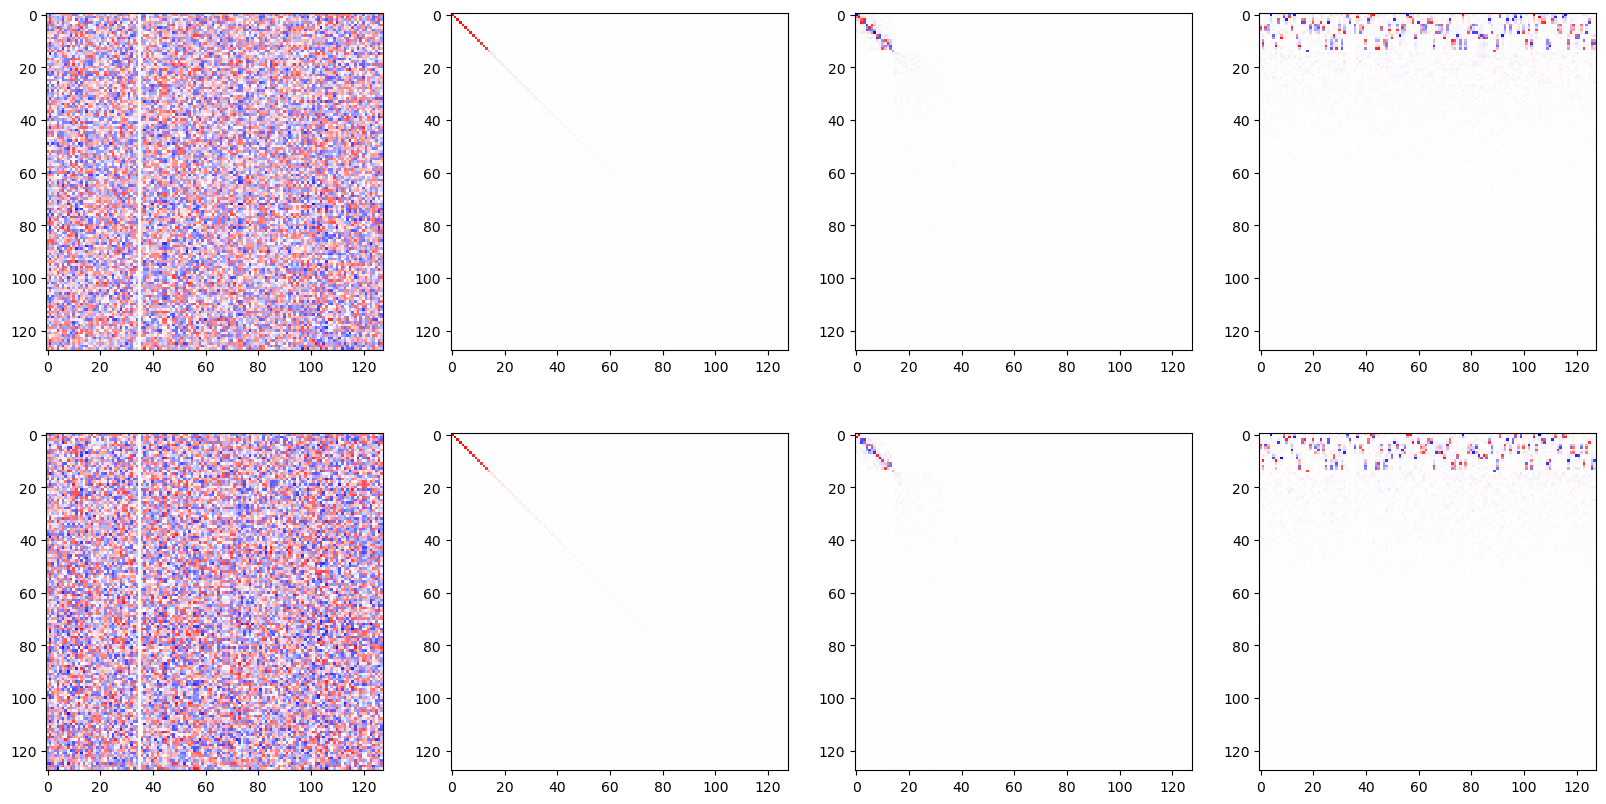

In [84]:
u_mlp, vt_mlp, s_mlp, w_mlp_diag = [None, None], [None, None], [None, None], [None, None]

fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(2):
    u_mlp[i], s_mlp[i], vt_mlp[i] = svd(w_mlp[i])
    w_mlp_diag[i] = u_mlp[i].T @ w_mlp[i] @ vt_mlp[i].T

    plot_matrix(w_mlp[i], axs[i,0])
    plot_matrix(w_mlp_diag[i], axs[i,1])
    plot_matrix(vt_emb @ u_mlp[i] @ w_mlp_diag[i], axs[i,2])
    plot_matrix(w_mlp_diag[i] @ vt_mlp[i], axs[i,3]);

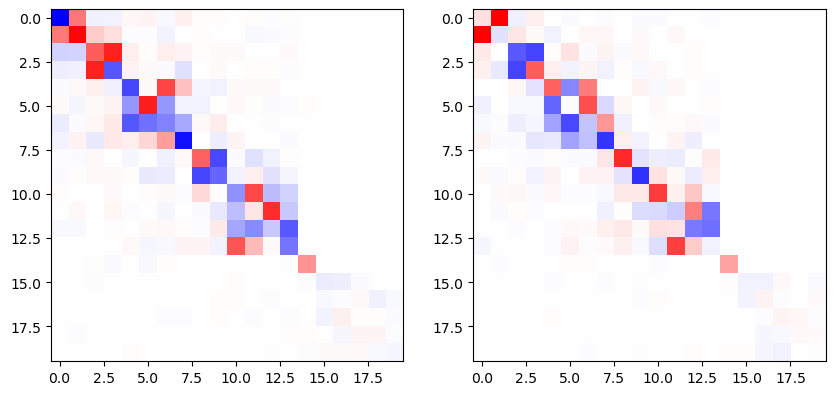

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

for i in range(2):
    plot_matrix((vt_emb @ u_mlp[i] @ w_mlp_diag[i])[:20,:20], axs[i])

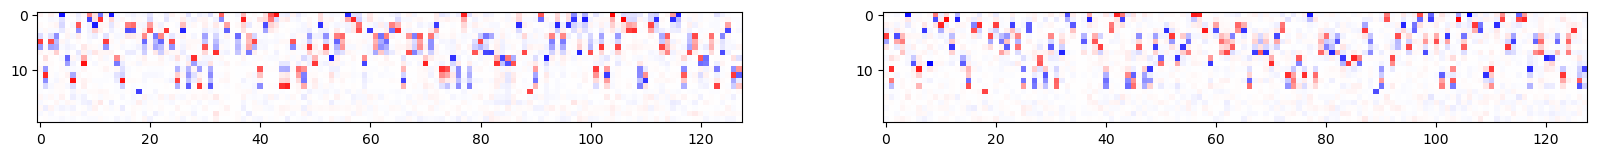

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

for i in range(2):
    plot_matrix((w_mlp_diag[i] @ vt_mlp[i])[:20], axs[i])

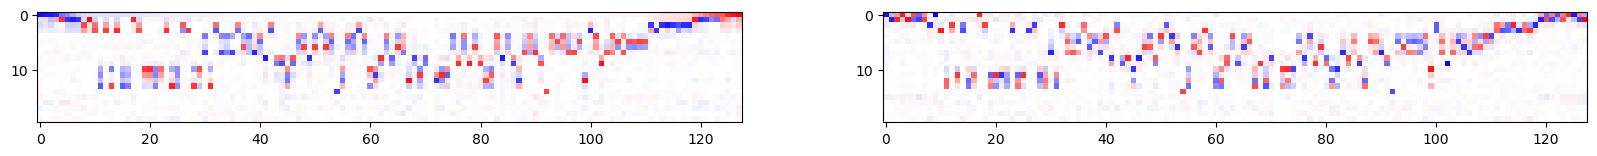

In [87]:
m0 = w_mlp_diag[0] @ vt_mlp[0]
m1 = w_mlp_diag[1] @ vt_mlp[1]

fig, axs = plt.subplots(1, 2, figsize=(20,5))
plot_matrix(m0[:,np.argsort(m0[0])][:20], axs[0])
plot_matrix(m1[:,np.argsort(m0[0])][:20], axs[1])


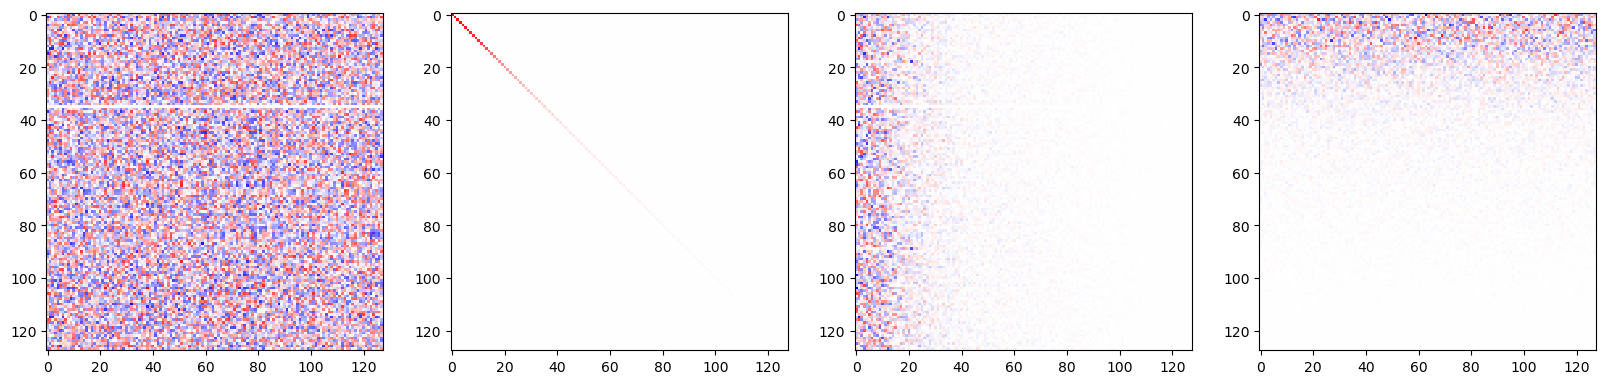

In [88]:
u_uem, s_uem, vt_uem = svd(w_uem)
w_uem_diag = u_uem.T @ w_uem @ vt_uem.T
fig, axs = plt.subplots(1,4, figsize=(20,5))
plot_matrix(w_uem, axs[0])
plot_matrix(w_uem_diag, axs[1])
plot_matrix(u_uem @ w_uem_diag, axs[2])
plot_matrix(w_uem_diag @ vt_uem, axs[3]);
#plot_matrix(u_uem, axs[2])
#plot_matrix(vt_uem, axs[3]);

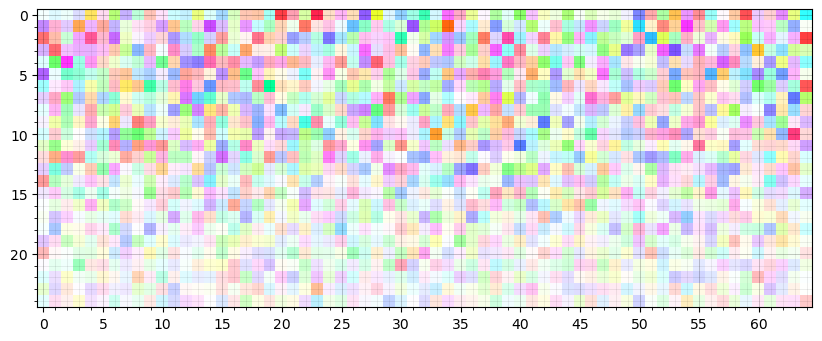

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

plot_fft((w_uem_diag @ vt_uem)[:25], ax, shift=+np.pi/2)

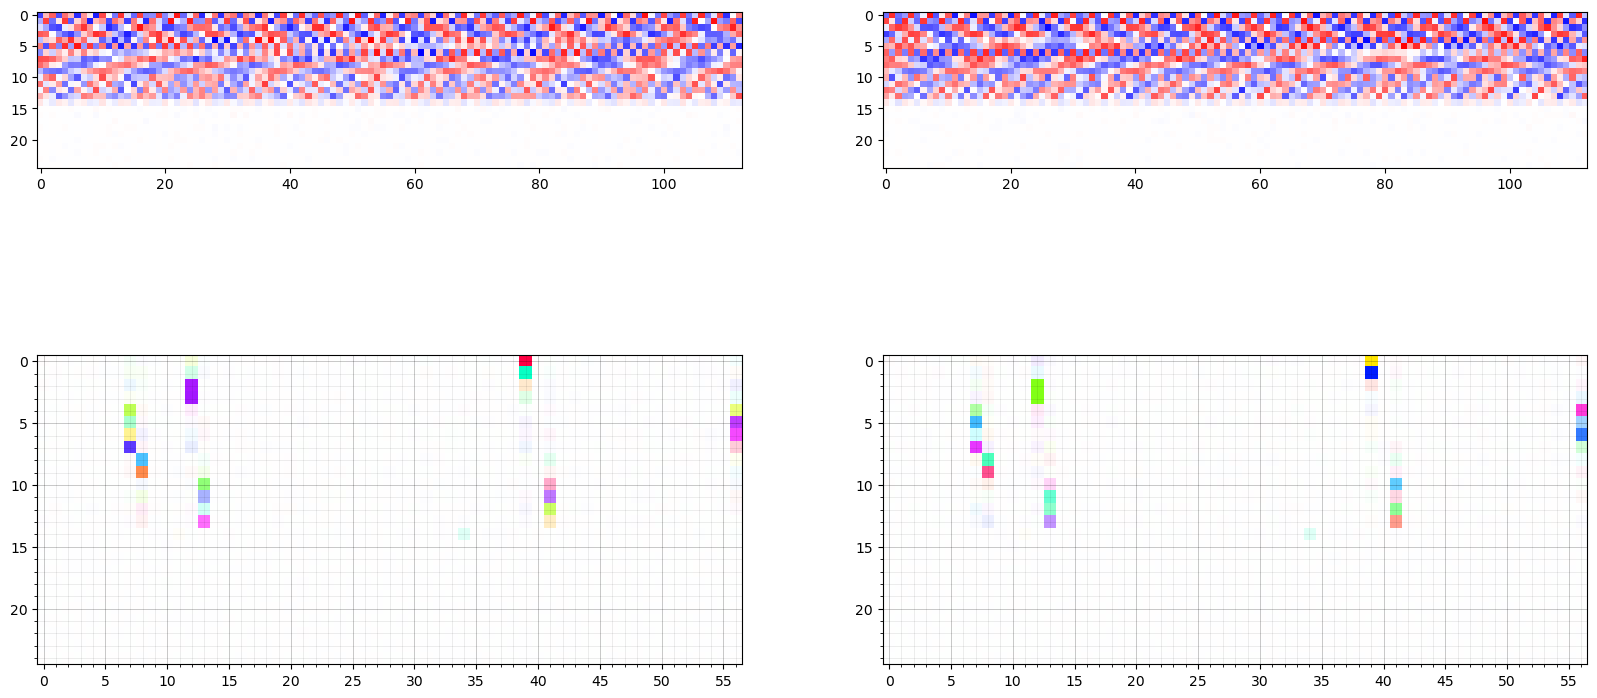

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))

m = u_emb @ w_emb_diag @ vt_emb @ u_mlp[0] @ w_mlp_diag[0]
plot_matrix(m.T[:25], axs[0,0])
plot_fft(m.T[:25], axs[1,0], shift=+np.pi/2)

m = u_emb @ w_emb_diag @ vt_emb @ u_mlp[1] @ w_mlp_diag[1]
plot_matrix(m.T[:25], axs[0,1])
plot_fft(m.T[:25], axs[1,1], shift=+np.pi/2)


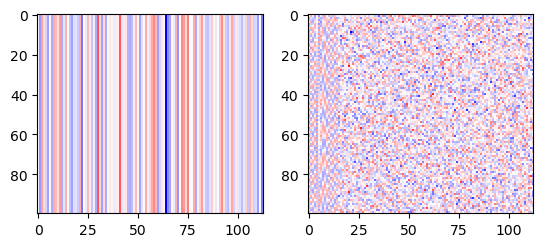

In [91]:
fig, ax = plt.subplots(1,2)

i0 = np.zeros((100,113))
i0[:,17] = 1

i1 = np.diag([1]*113)[:100]

plot_matrix(i0 @ u_emb, ax[0]);
plot_matrix(i1 @ u_emb, ax[1]);

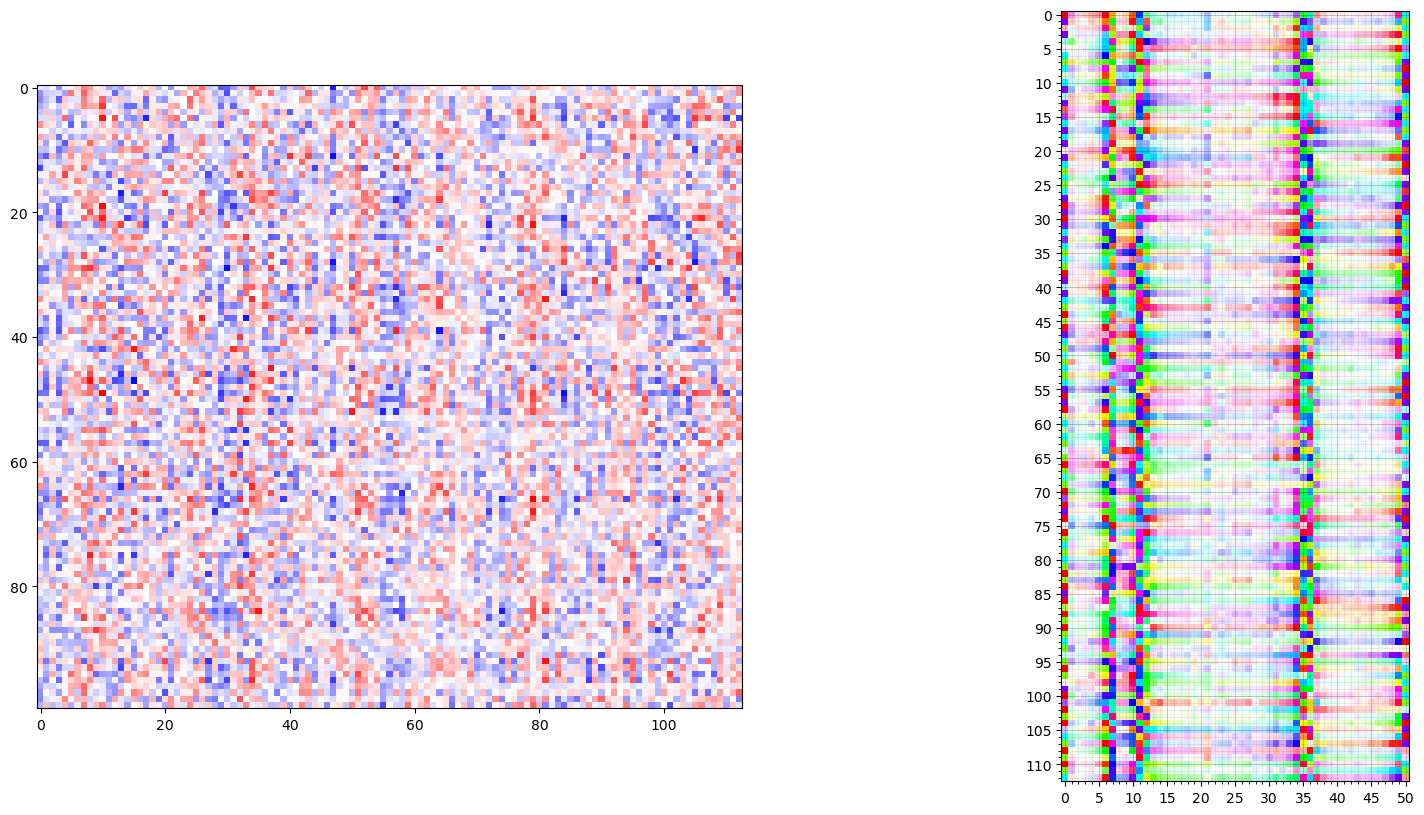

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

#m1 = i0 @ u_emb @ w_emb_diag @ vt_emb @ u_mlp[0] @ w_mlp_diag[0] @ vt_mlp[0]
#m2 = i1 @ u_emb @ w_emb_diag @ vt_emb @ u_mlp[1] @ w_mlp_diag[1] @ vt_mlp[1]
m1 = i0 @ w_emb @ w_mlp[0]
m2 = i1 @ w_emb @ w_mlp[1]
#m = gelu(m1 + m2) @ u_uem @ w_uem_diag @ vt_uem
m = gelu(m1 + m2) @ w_uem @ w_emb.T
plot_matrix(m, axs[0], scale=1)
plot_fft(m.T, axs[1], shift=-np.pi/2, scale=8)

4/4 [==============================] - 0s 6ms/step


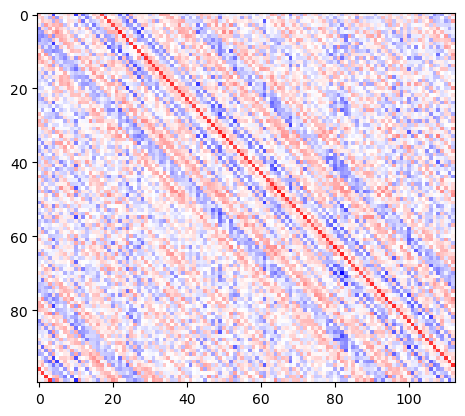

In [123]:
inp = np.stack([
    np.ones(100, dtype=int) * 17,
    np.arange(100)
], axis=-1)
m = model.predict(inp)

fig, ax = plt.subplots(1,1)
plot_matrix(m, ax)

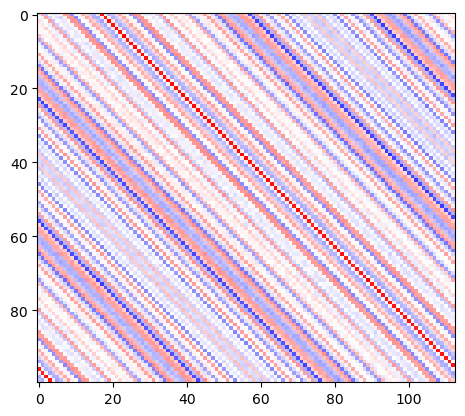

In [23]:
fig, ax = plt.subplots(1,1)

m[:,14:]=0
plot_matrix(m @ vt_uem, ax)

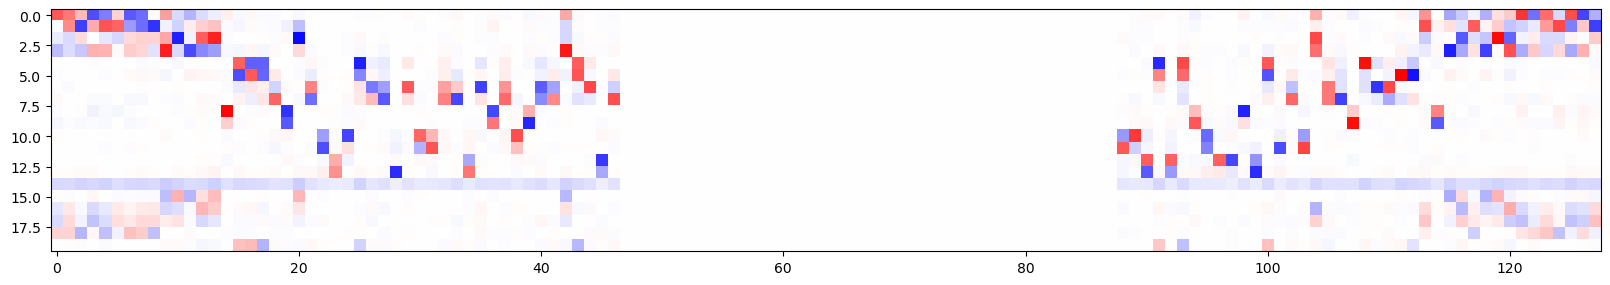

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

plot_matrix((u_uem @ w_uem_diag)[np.argsort(m0[0]),:20].T, ax)

In [130]:
model.get_config()

{'name': 'mlp_grokking',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 2),
    'dtype': 'int32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'},
   'name': 'input_2',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_1',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 2),
    'input_dim': 113,
    'output_dim': 128,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 2},
   'name': 'embedding_1',
   'inbound_nodes': [[['input_2', 0, 0, {}]]]},
  {'class_name': 'TFOpLambda',
   'config': {'name': 'tf.expand_dims_1',
    'trainable': True,
    'dtype': 'float32',
    'function': 'expand_dims'},
   'name': 'tf.expand_dims_1',
   'inbound_nodes': [

In [110]:
extractor = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

In [111]:
ext_out = extractor.predict(inp)
print([ o.shape for o in ext_out ])


4/4 [==============================] - 0s 11ms/step
[(100, 2), (100, 2, 128), (100, 2, 128, 1), (100, 1, 1, 128), (100, 1, 1, 128), (100, 128), (100, 128), (100, 113)]


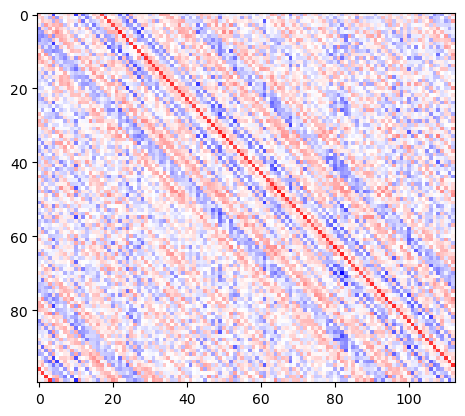

In [124]:
fig, ax = plt.subplots(1,1)
plot_matrix(ext_out[7][:,:], ax)